In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 619.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 81.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 118.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 87.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 16.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 5.8 MB/s eta 0:00:00


Reutilizamos el archivo dataset_completo.csv creado en el cuaderno Jupiter_nn para obtener las direcciones de cada imagen y el nombre de la carpeta principal para la categoria

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Proyecto Jupiter/dataset_completo.csv')

# Diccionario clase → índice
label_to_index = {label: idx for idx, label in enumerate(sorted(df['tipo'].unique()))}
df['label'] = df['tipo'].map(label_to_index)

# Split estratificado
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

In [ ]:
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

def decode_img(path, label):
    img = tf.io.read_file(path)

    # Detectamos por extensión
    ext = tf.strings.lower(tf.strings.split(path, '.')[-1])

    def decode_jpg(): return tf.image.decode_jpeg(img, channels=3)
    def decode_png(): return tf.image.decode_png(img, channels=3)

    img = tf.cond(tf.equal(ext, 'png'), decode_png, decode_jpg)

    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

def df_to_dataset(df, shuffle=True):
    paths = df['ruta'].values
    labels = df['label'].values
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(decode_img, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df))
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

train_ds = df_to_dataset(train_df)
test_ds = df_to_dataset(test_df, shuffle=False)

# Prueba de restar la media de colores intentando difuminar el fondo

In [ ]:
!pip install opencv-python-headless

import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import cv2
import os
from tqdm import tqdm

# Tamaño reducido para capturar color global
IMG_SIZE = (128, 128)

def extract_color_vector_from_path(path):
    img_bytes = tf.io.read_file(path)
    ext = tf.strings.lower(tf.strings.split(path, '.')[-1])

    def decode_jpg(): return tf.image.decode_jpeg(img_bytes, channels=3)
    def decode_png(): return tf.image.decode_png(img_bytes, channels=3)

    img = tf.cond(tf.equal(ext, 'png'), decode_png, decode_jpg)
    img.set_shape([None, None, 3])  # <- Esto es clave

    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    mean_color = tf.reduce_mean(img, axis=[0, 1])
    return mean_color

paths = tf.constant(df['ruta'].values)

ds = tf.data.Dataset.from_tensor_slices(paths)
ds = ds.map(extract_color_vector_from_path, num_parallel_calls=tf.data.AUTOTUNE)
ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
# 1. Seleccionamos una muestra estratificada
sample_df = df.groupby('label', group_keys=False).apply(lambda x: x.sample(min(len(x), 100), random_state=42))
sample_paths = sample_df['ruta'].values

# 2. Creamos un dataset con esa muestra
sample_ds = tf.data.Dataset.from_tensor_slices(sample_paths)
sample_ds = sample_ds.map(extract_color_vector_from_path, num_parallel_calls=tf.data.AUTOTUNE)
sample_ds = sample_ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# 3. Calculamos el color medio del fondo
background_colors = np.vstack([batch.numpy() for batch in sample_ds])
background_mean = np.mean(background_colors, axis=0)

/tmp/ipython-input-7-2891969153.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sample_df = df.groupby('label', group_keys=False).apply(lambda x: x.sample(min(len(x), 100), random_state=42))


In [ ]:
# 4. Función corregida por resta del color de fondo
def get_corrected_color_vector(img_color):
    return img_color - background_mean

# 5. Aplicamos la corrección a todo el dataset (ya procesado arriba como `ds`)
corrected_color_vectors = np.vstack([
    get_corrected_color_vector(batch.numpy())
    for batch in ds
])

# 6. Etiquetas
labels = df['label'].values

In [ ]:
# Guardamos los vectores corregidos y etiquetas en formato .npz (compacto)
np.savez_compressed(
    '/content/drive/MyDrive/Proyecto Jupiter/color_vectors_corregidos.npz',
    X=corrected_color_vectors,
    y=labels
)

In [ ]:
# Cargar directamente desde archivo .npz si ya lo tienes calculado
data = np.load('/content/drive/MyDrive/Proyecto Jupiter/color_vectors_corregidos.npz')
corrected_color_vectors = data['X']
labels = data['y']

Probamos una reducción de la dimensionalidad a 2 dimensiones para poder visualizarlo, sin mucha esperanza

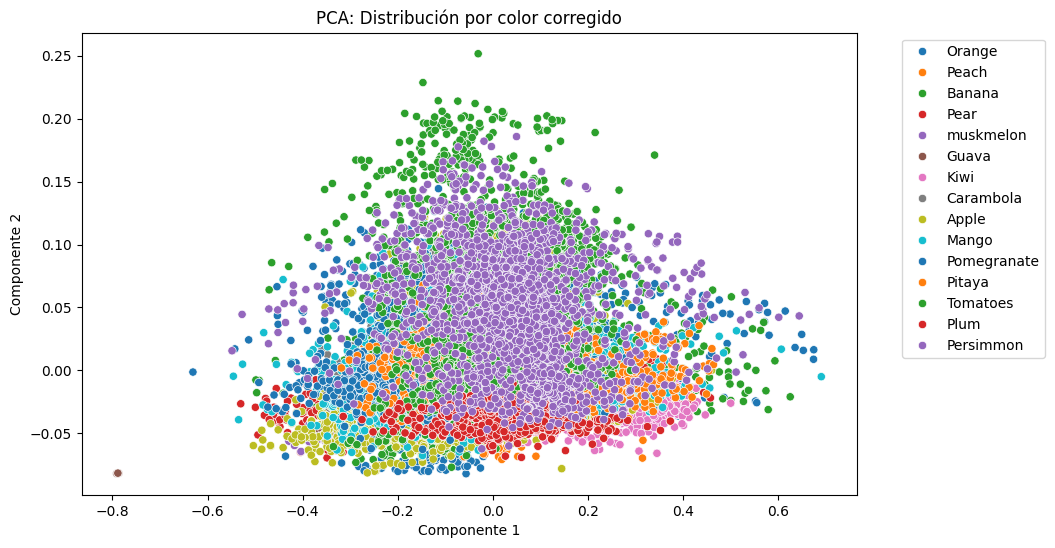

In [ ]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

# Opcional: PCA a 2D
pca = PCA(n_components=2)
reduced_pca = pca.fit_transform(corrected_color_vectors)

# Visualización
plt.figure(figsize=(10, 6))
sns.scatterplot(x=reduced_pca[:, 0], y=reduced_pca[:, 1], hue=df['tipo'], palette='tab10')
plt.title("PCA: Distribución por color corregido")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    corrected_color_vectors, labels, test_size=0.2, stratify=labels, random_state=42
)

clf = SVC(kernel='rbf')  # o 'linear'
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred, target_names=df['tipo'].unique()))

              precision    recall  f1-score   support

      Orange       0.42      0.61      0.50      2237
       Peach       0.67      0.17      0.27       605
      Banana       0.89      0.53      0.66       416
        Pear       0.66      0.97      0.79      3940
   muskmelon       0.58      0.71      0.64      1697
       Guava       0.62      0.35      0.45       831
        Kiwi       0.81      0.56      0.66       602
   Carambola       0.50      0.00      0.00       526
       Apple       0.33      0.01      0.02       602
       Mango       0.85      0.54      0.66       414
 Pomegranate       0.54      0.55      0.55       500
      Pitaya       0.66      0.69      0.68       460
    Tomatoes       0.49      0.31      0.38       433
        Plum       0.86      0.38      0.52       435
   Persimmon       0.00      0.00      0.00       416

    accuracy                           0.60     14114
   macro avg       0.59      0.43      0.45     14114
weighted avg       0.59   

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


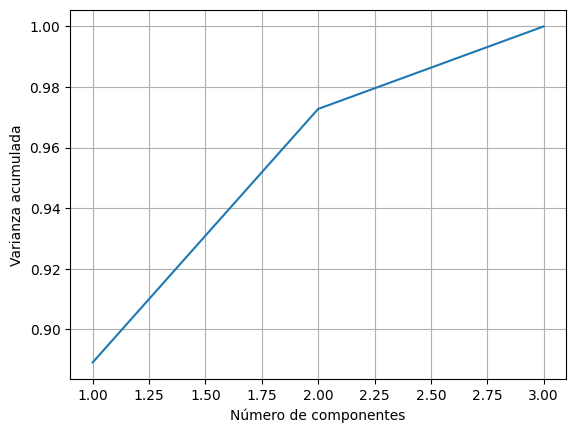

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

pca = PCA()
pca.fit(corrected_color_vectors)

# Varianza explicada acumulada
explained_variance = np.cumsum(pca.explained_variance_ratio_)

plt.plot(range(1, len(explained_variance)+1), explained_variance)
plt.xlabel('Número de componentes')
plt.ylabel('Varianza acumulada')
plt.grid(True)
plt.show()

# filtro de pixeles comunes

Si hacemos la interseccion de los conjuntos de los pixeles de las imagenes obtendremos los comunes a todas las imagenes, debería estar gran parte del fondo y quiza algo de algunas frutas  
Hacemos una selección de 10 imagenes por tipo, manzanas añadimos al haber diferentes subtipos muy diferenciados de las que son más normalizadas. Bandeja alineada, sin flash, sin reflejo, sin oscuridad, sin manos...

In [ ]:
import os
from PIL import Image
import numpy as np

# Ruta base donde están las imágenes
base_path = '/content/drive/MyDrive/Proyecto Jupiter/archive'

# Carpetas que deben ignorarse si contienen estas palabras
excluir_carpetas = ["total", "Total"]

# Carpetas de las que tomaremos las 10 últimas imágenes
ultimas_carpetas = ["Apple F", "Mango", "Peach", "Pitaya", "Plum"]

# Rangos específicos por nombre de fruta
rango_manual = {
    "Banana": ["Banana0899.png", "Banana0900.png", "Banana0901.png", "Banana0902.png",
               "Banana0903.png", "Banana0904.png", "Banana0905.png", "Banana0906.png",
               "Banana0907.png", "Banana0908.png"],
    "Carambola": [f"Carambola 00{i:03d}.png" for i in range(193, 203)],
    "muskmelon": [f"Muskmelon 00{i:04d}.png" for i in range(2063, 2073)],
    "Orange": ([f"Orange00{i:04d}.png" for i in range(2924, 2930)] +
               [f"Orange00{i:04d}.png" for i in range(2931, 2935)]),
    "Pear": ([f"Pear {i}.png" for i in range(4, 11)] +
             [f"Pear {i}.png" for i in range(14, 18)]),
    "Persimmon": [f"Persimmon20{i:02d}.png" for i in range(19, 29)],
    "Pomegranate": [f"Pomegranet0014{i:02d}.png" for i in range(62, 72)],
    "Tomatoes": [f"Tamotoes0020{i:02d}.png" for i in range(87, 97)],
}

# Función para obtener colores únicos de una imagen (como tuplas RGB)
def cargar_colores_unicos(imagen_path, size=(256, 256)):
    try:
        with Image.open(imagen_path).convert("RGB") as img:
            img = img.resize(size)
            arr = np.array(img)
            colores = set(tuple(color) for fila in arr for color in fila)
            return colores
    except Exception as e:
        print(f"Error procesando {imagen_path}: {e}")
        return set()

colores_comunes = None
contador = 0

for fruta in os.listdir(base_path):
    fruta_path = os.path.join(base_path, fruta)
    if not os.path.isdir(fruta_path):
        continue

    # Listar elementos dentro de la carpeta fruta
    elementos = os.listdir(fruta_path)

    # Detectar si hay subcarpetas o solo imágenes
    hay_subcarpetas = any(os.path.isdir(os.path.join(fruta_path, el)) for el in elementos)

    if hay_subcarpetas:
        # Caso con subcarpetas (subtipos)
        for subcarpeta in elementos:
            if any(palabra in subcarpeta for palabra in excluir_carpetas):
                continue

            sub_path = os.path.join(fruta_path, subcarpeta)
            if not os.path.isdir(sub_path):
                continue

            imagenes_archivos = sorted([f for f in os.listdir(sub_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            seleccionadas = []

            if fruta in rango_manual:
                seleccionadas = [f for f in imagenes_archivos if f in rango_manual[fruta]]
            elif subcarpeta in ultimas_carpetas:
                seleccionadas = imagenes_archivos[-10:]
            else:
                seleccionadas = imagenes_archivos[:10]

            for img_name in seleccionadas:
                img_path = os.path.join(sub_path, img_name)
                colores_img = cargar_colores_unicos(img_path)

                if colores_comunes is None:
                    colores_comunes = colores_img
                else:
                    colores_comunes = colores_comunes.intersection(colores_img)

                contador += 1
                print(f"{contador} imágenes procesadas - colores comunes actuales: {len(colores_comunes)}")
    else:
        # Caso sin subcarpetas: imágenes directamente dentro de la carpeta fruta
        imagenes_archivos = sorted([f for f in elementos if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        seleccionadas = []

        if fruta in rango_manual:
            seleccionadas = [f for f in imagenes_archivos if f in rango_manual[fruta]]
        elif fruta in ultimas_carpetas:
            seleccionadas = imagenes_archivos[-10:]
        else:
            seleccionadas = imagenes_archivos[:10]

        for img_name in seleccionadas:
            img_path = os.path.join(fruta_path, img_name)
            colores_img = cargar_colores_unicos(img_path)

            if colores_comunes is None:
                colores_comunes = colores_img
            else:
                colores_comunes = colores_comunes.intersection(colores_img)

            contador += 1
            print(f"{contador} imágenes procesadas - colores comunes actuales: {len(colores_comunes)}")

print("\n🧪 RESULTADO FINAL:")
print(f"Total de imágenes procesadas: {contador}")
print(f"Colores comunes en todas las imágenes: {len(colores_comunes)}")
print(f"Proporción sobre los 16.581.375 colores posibles: {len(colores_comunes) / 16581375 * 100:.8f}%")

1 imágenes procesadas - colores comunes actuales: 46016
2 imágenes procesadas - colores comunes actuales: 3088
3 imágenes procesadas - colores comunes actuales: 502
4 imágenes procesadas - colores comunes actuales: 149
5 imágenes procesadas - colores comunes actuales: 80
6 imágenes procesadas - colores comunes actuales: 52
7 imágenes procesadas - colores comunes actuales: 31
8 imágenes procesadas - colores comunes actuales: 27
9 imágenes procesadas - colores comunes actuales: 20
10 imágenes procesadas - colores comunes actuales: 20
11 imágenes procesadas - colores comunes actuales: 19
12 imágenes procesadas - colores comunes actuales: 15
13 imágenes procesadas - colores comunes actuales: 15
14 imágenes procesadas - colores comunes actuales: 15
15 imágenes procesadas - colores comunes actuales: 15
16 imágenes procesadas - colores comunes actuales: 15
17 imágenes procesadas - colores comunes actuales: 14
18 imágenes procesadas - colores comunes actuales: 14
19 imágenes procesadas - color

# Pixeles comunes sin redimensionamiento para filtro

El resultado anterior ha sido catastrófico habiendo tomado muy pocas fotos. Probaremos sin el redimensionado para evitar la difuminación de los colores de los pixeles para ver si nos da un mejor resultado

In [ ]:
import os
from PIL import Image
import numpy as np

base_path = '/content/drive/MyDrive/Proyecto Jupiter/archive'
excluir_carpetas = ["total", "Total"]
ultimas_carpetas = ["Apple F", "Mango", "Peach", "Pitaya", "Plum"]

rango_manual = {
    "Banana": ["Banana0899.png", "Banana0900.png", "Banana0901.png", "Banana0902.png",
               "Banana0903.png", "Banana0904.png", "Banana0905.png", "Banana0906.png",
               "Banana0907.png", "Banana0908.png"],
    "Carambola": [f"Carambola 00{i:03d}.png" for i in range(193, 203)],
    "muskmelon": [f"Muskmelon 00{i:04d}.png" for i in range(2063, 2073)],
    "Orange": ([f"Orange00{i:04d}.png" for i in range(2924, 2930)] +
               [f"Orange00{i:04d}.png" for i in range(2931, 2935)]),
    "Pear": ([f"Pear {i}.png" for i in range(4, 11)] +
             [f"Pear {i}.png" for i in range(14, 18)]),
    "Persimmon": [f"Persimmon20{i:02d}.png" for i in range(19, 29)],
    "Pomegranate": [f"Pomegranet0014{i:02d}.png" for i in range(62, 72)],
    "Tomatoes": [f"Tamotoes0020{i:02d}.png" for i in range(87, 97)],
}

# --- parámetros robustos ---
TARGET_SIZE = (256, 256)     # si quieres comparar a igual tamaño, evita interpolación
NIVELES = 32                 # 16/32/64: prueba varios
FACTOR = 256 // NIVELES      # tamaño del bin por canal

def cuantizar(arr):
    # agrupa colores: 0..255 -> 0,8,16.. (si NIVELES=32 => salto=8)
    return (arr // FACTOR) * FACTOR

def cargar_bins_unicos(imagen_path, size=TARGET_SIZE):
    try:
        with Image.open(imagen_path).convert("RGB") as img:
            # evita difuminado de colores:
            img = img.resize(size, resample=Image.NEAREST)
            arr = np.array(img, dtype=np.uint8)
            arr_q = cuantizar(arr)
            # convertimos a tuplas de bins
            h, w, _ = arr_q.shape
            arr_flat = arr_q.reshape(-1, 3)
            colores = set(map(tuple, arr_flat))
            return colores, (h*w), arr_q  # devolvemos también imagen cuantizada para cobertura
    except Exception as e:
        print(f"Error procesando {imagen_path}: {e}")
        return set(), 0, None

bins_comunes = None
contador = 0
num_pix_totales_por_img = []
imagenes_q = []   # guardamos algunas cuantizadas para cobertura
rutas_procesadas = []

def procesa_lista(ruta_base, archivos, etiqueta):
    global bins_comunes, contador
    for img_name in archivos:
        img_path = os.path.join(ruta_base, img_name)
        colores_img, n_pix, arr_q = cargar_bins_unicos(img_path)
        if n_pix == 0:
            continue
        if bins_comunes is None:
            bins_comunes = colores_img
        else:
            bins_comunes = bins_comunes.intersection(colores_img)
        contador += 1
        num_pix_totales_por_img.append(n_pix)
        if arr_q is not None:
            imagenes_q.append(arr_q)
            rutas_procesadas.append(img_path)
        print(f"{contador} imágenes procesadas [{etiqueta}] - bins comunes actuales: {len(bins_comunes)}")

for fruta in os.listdir(base_path):
    fruta_path = os.path.join(base_path, fruta)
    if not os.path.isdir(fruta_path):
        continue

    elementos = os.listdir(fruta_path)
    hay_subcarpetas = any(os.path.isdir(os.path.join(fruta_path, el)) for el in elementos)

    if hay_subcarpetas:
        for subcarpeta in elementos:
            if any(pal in subcarpeta for pal in excluir_carpetas):
                continue
            sub_path = os.path.join(fruta_path, subcarpeta)
            if not os.path.isdir(sub_path):
                continue

            imagenes_archivos = sorted([f for f in os.listdir(sub_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            if fruta in rango_manual:
                seleccionadas = [f for f in imagenes_archivos if f in rango_manual[fruta]]
            elif subcarpeta in ultimas_carpetas:
                seleccionadas = imagenes_archivos[-10:]
            else:
                seleccionadas = imagenes_archivos[:10]

            procesa_lista(sub_path, seleccionadas, etiqueta=f"{fruta}/{subcarpeta}")
    else:
        imagenes_archivos = sorted([f for f in elementos if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        if fruta in rango_manual:
            seleccionadas = [f for f in imagenes_archivos if f in rango_manual[fruta]]
        elif fruta in ultimas_carpetas:
            seleccionadas = imagenes_archivos[-10:]
        else:
            seleccionadas = imagenes_archivos[:10]

        procesa_lista(fruta_path, seleccionadas, etiqueta=fruta)

# --- cobertura: ¿qué % de píxeles caerían en los bins comunes? ---
def cobertura_por_imagen(arr_q, bins_comunes):
    h, w, _ = arr_q.shape
    flat = arr_q.reshape(-1, 3)
    # vectorizado: comparamos cada píxel con set -> convertimos set a matriz y comparamos
    # para no explotar memoria: usamos un truco con vista estructurada para usar np.isin en 3 canales
    dtype = np.dtype((np.void, flat.dtype.itemsize * flat.shape[1]))
    flat_view = flat.view(dtype).ravel()
    bins_arr = np.array(list(bins_comunes), dtype=np.uint8)
    bins_view = bins_arr.view(dtype).ravel()
    mask = np.isin(flat_view, bins_view)
    return mask.mean()  # proporción [0,1]

coberturas = []
for arr_q in imagenes_q:
    cob = cobertura_por_imagen(arr_q, bins_comunes) if bins_comunes else 0.0
    coberturas.append(cob)

media_cobertura = float(np.mean(coberturas)) if coberturas else 0.0
p95_cobertura = float(np.percentile(coberturas, 95)) if coberturas else 0.0

print("\n🧪 RESULTADO FINAL (ROBUSTO):")
print(f"Total de imágenes procesadas: {contador}")
print(f"Bins (colores cuantizados) comunes en todas las imágenes: {len(bins_comunes) if bins_comunes else 0}")
total_bins_posibles = NIVELES**3
proporcion_bins = (len(bins_comunes) / total_bins_posibles * 100) if bins_comunes else 0
print(f"Proporción sobre los {total_bins_posibles} bins posibles: {proporcion_bins:.6f}%")
print(f"Cobertura media de píxeles que caerían en bins COMUNES (pérdida si los filtras): {media_cobertura*100:.3f}%")
print(f"Cobertura p95 (casos más 'peligrosos'): {p95_cobertura*100:.3f}%")
print(f"Niveles por canal usados: {NIVELES} (bin={FACTOR}) | Resize: NEAREST")

1 imágenes procesadas [Orange] - bins comunes actuales: 3029
2 imágenes procesadas [Orange] - bins comunes actuales: 1153
3 imágenes procesadas [Orange] - bins comunes actuales: 976
4 imágenes procesadas [Orange] - bins comunes actuales: 884
5 imágenes procesadas [Orange] - bins comunes actuales: 735
6 imágenes procesadas [Orange] - bins comunes actuales: 665
7 imágenes procesadas [Orange] - bins comunes actuales: 642
8 imágenes procesadas [Orange] - bins comunes actuales: 629
9 imágenes procesadas [Orange] - bins comunes actuales: 543
10 imágenes procesadas [Orange] - bins comunes actuales: 532
11 imágenes procesadas [Peach] - bins comunes actuales: 478
12 imágenes procesadas [Peach] - bins comunes actuales: 452
13 imágenes procesadas [Peach] - bins comunes actuales: 437
14 imágenes procesadas [Peach] - bins comunes actuales: 434
15 imágenes procesadas [Peach] - bins comunes actuales: 418
16 imágenes procesadas [Peach] - bins comunes actuales: 413
17 imágenes procesadas [Peach] - bins

In [ ]:
# Guardar los pixeles comunes
import pickle
bins_path = "/content/drive/MyDrive/Proyecto Jupiter/bins_comunes.pkl"

def guardar_bins(bins, path=bins_path):
    with open(path, "wb") as f:
        pickle.dump(list(bins), f)
    print(f"✅ Bins comunes guardados en {path}")

guardar_bins(bins_comunes)

✅ Bins comunes guardados en /content/drive/MyDrive/Proyecto Jupiter/bins_comunes.pkl


In [ ]:
# Cargar los pixeles comunes
import pickle
def cargar_bins(path=bins_path):
    with open(path, "rb") as f:
        bins = set(tuple(x) for x in pickle.load(f))
    print(f"✅ Bins comunes cargados ({len(bins)} bins)")
    return bins
bins_comunes = cargar_bins()

✅ Bins comunes cargados (165 bins)


In [ ]:
import matplotlib.pyplot as plt
# --- APLICAR FILTRO A UNA IMAGEN ---
def aplicar_filtro(imagen_path, bins, size=TARGET_SIZE):
    with Image.open(imagen_path).convert("RGB") as img:
        img = img.resize(size, resample=Image.NEAREST)
        arr = np.array(img, dtype=np.uint8)
        arr_q = cuantizar(arr)

        # Creamos máscara de píxeles comunes
        flat = arr_q.reshape(-1, 3)
        dtype = np.dtype((np.void, flat.dtype.itemsize * flat.shape[1]))
        flat_view = flat.view(dtype).ravel()
        bins_arr = np.array(list(bins), dtype=np.uint8)
        bins_view = bins_arr.view(dtype).ravel()
        mask = np.isin(flat_view, bins_view).reshape(arr_q.shape[:2])

        # Copia de la imagen: ponemos en negro los píxeles comunes
        filtrada = arr.copy()
        filtrada[mask] = [0, 0, 0]

        return img, Image.fromarray(filtrada)

# --- VISUALIZAR COMPARACIÓN ---
def mostrar_comparacion(imagen_path, bins):
    original, filtrada = aplicar_filtro(imagen_path, bins)
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(original)
    axs[0].set_title("Original")
    axs[0].axis("off")
    axs[1].imshow(filtrada)
    axs[1].set_title("Filtrada")
    axs[1].axis("off")
    plt.show()

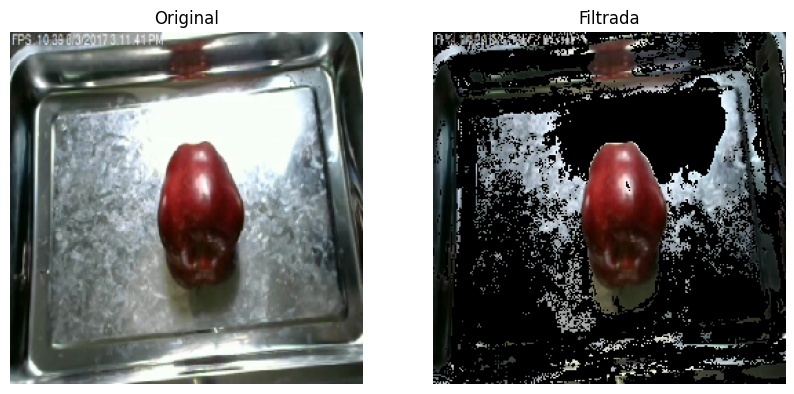

In [ ]:
mostrar_comparacion("/content/drive/MyDrive/Proyecto Jupiter/archive/Apple/Apple B/113red applee01101113.png", bins_comunes)


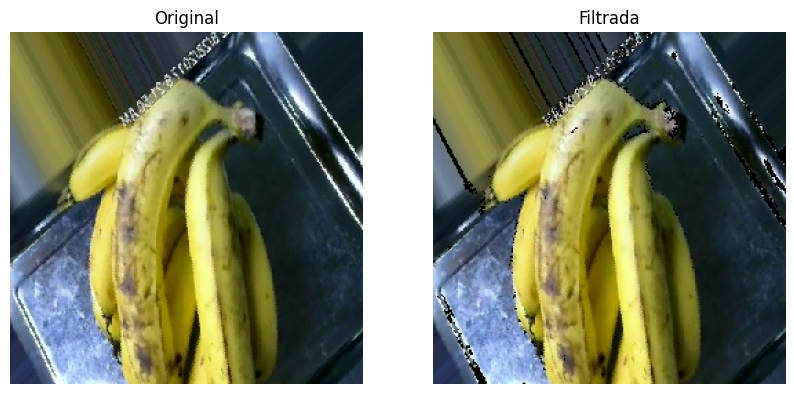

In [ ]:
mostrar_comparacion("/content/drive/MyDrive/Proyecto Jupiter/archive/Banana/Banana0156.png", bins_comunes)

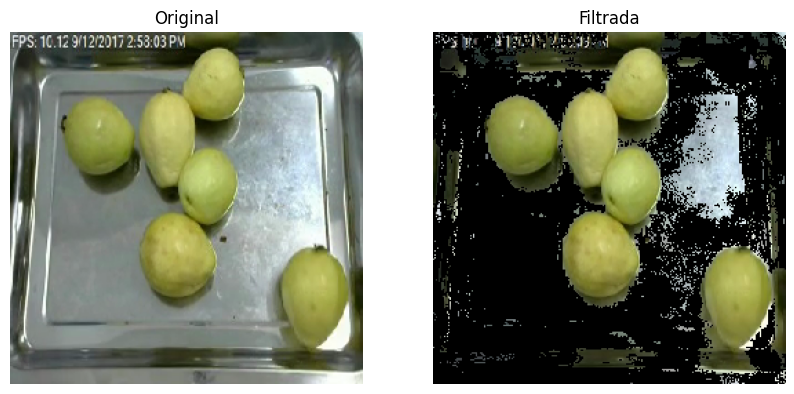

In [ ]:
mostrar_comparacion("/content/drive/MyDrive/Proyecto Jupiter/archive/Guava/guava B/Guava49.png", bins_comunes)

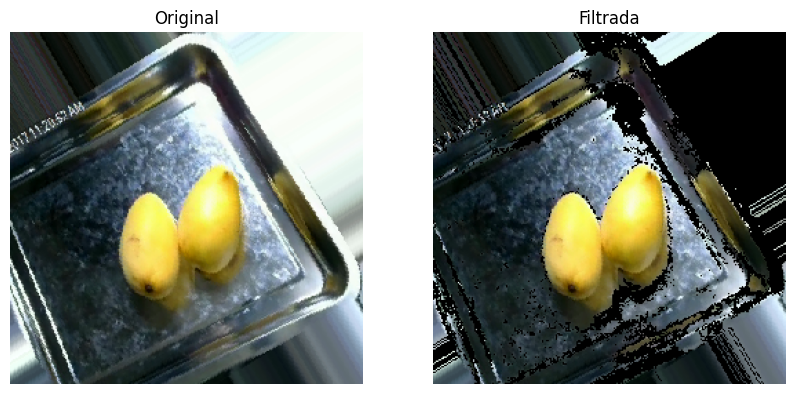

In [ ]:
mostrar_comparacion("/content/drive/MyDrive/Proyecto Jupiter/archive/Mango/Mango0015.png", bins_comunes)

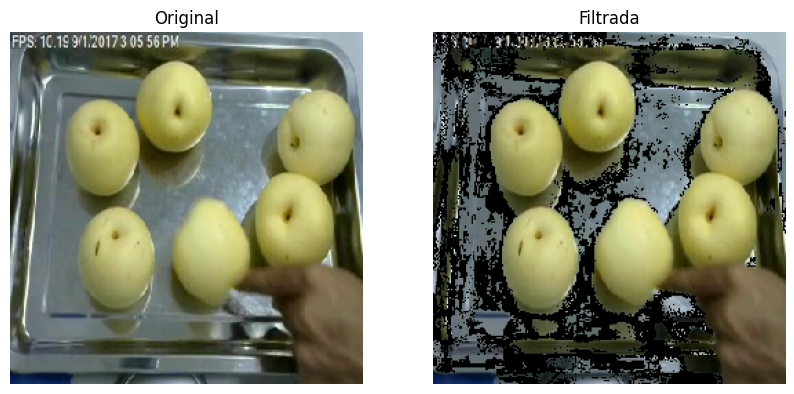

In [ ]:
mostrar_comparacion("/content/drive/MyDrive/Proyecto Jupiter/archive/Pear/Pear 12.png", bins_comunes)

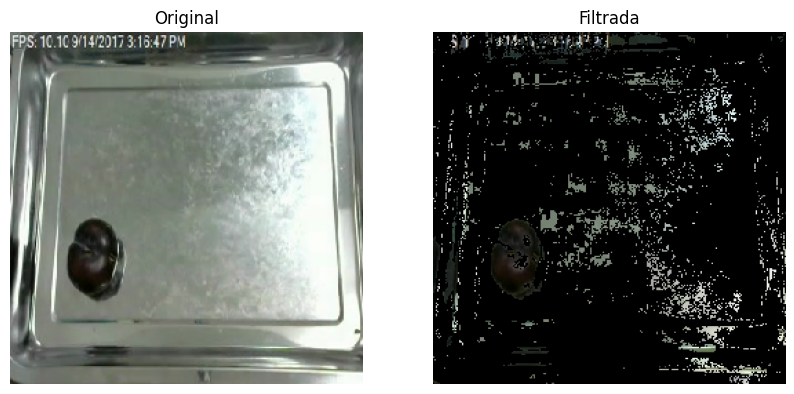

In [ ]:
mostrar_comparacion("/content/drive/MyDrive/Proyecto Jupiter/archive/Plum/PlumÒÇé1628.png", bins_comunes)

# pixeles unicos por tipo de fruta

Si hacemos la intersección de los colores de los pixeles de las imagenes de un tipo de fruta y a este conjunto le restamos la intersección del mismo grupo con la intersección de los colores de cada uno de los otros grupos nos quedaremos con el conjunto de colores de pixeles únicos de cada tipo de fruta

In [ ]:
import os
from PIL import Image
import numpy as np
import pandas as pd
from collections import defaultdict
from tqdm import tqdm

# Ruta principal
base_path = '/content/drive/MyDrive/Proyecto Jupiter/archive'

# Configuración de selección
excluir_carpetas = ["total", "Total"]
ultimas_carpetas = ["Apple F", "Mango", "Peach", "Pitaya", "Plum"]
rango_manual = {
    "Banana": ["Banana0899.png", "Banana0900.png", "Banana0901.png", "Banana0902.png",
               "Banana0903.png", "Banana0904.png", "Banana0905.png", "Banana0906.png",
               "Banana0907.png", "Banana0908.png"],
    "Carambola": [f"Carambola 00{i:03d}.png" for i in range(193, 203)],
    "muskmelon": [f"Muskmelon 00{i:04d}.png" for i in range(2063, 2073)],
    "Orange": ([f"Orange00{i:04d}.png" for i in range(2924, 2930)] +
               [f"Orange00{i:04d}.png" for i in range(2931, 2935)]),
    "Pear": ([f"Pear {i}.png" for i in range(4, 11)] +
             [f"Pear {i}.png" for i in range(14, 18)]),
    "Persimmon": [f"Persimmon20{i:02d}.png" for i in range(19, 29)],
    "Pomegranate": [f"Pomegranet0014{i:02d}.png" for i in range(62, 72)],
    "Tomatoes": [f"Tamotoes0020{i:02d}.png" for i in range(87, 97)],
}

# Función para extraer colores únicos de una imagen
def cargar_colores_unicos(imagen_path, size=(256, 256)):
    try:
        with Image.open(imagen_path).convert("RGB") as img:
            img = img.resize(size)
            arr = np.array(img)
            return set(tuple(color) for fila in arr for color in fila)
    except:
        return set()

# Paso 1: Seleccionar imágenes siguiendo tus reglas
datos_imagenes = []

for tipo in os.listdir(base_path):
    tipo_path = os.path.join(base_path, tipo)
    if not os.path.isdir(tipo_path):
        continue

    subelementos = os.listdir(tipo_path)
    hay_subcarpetas = any(os.path.isdir(os.path.join(tipo_path, s)) for s in subelementos)

    if hay_subcarpetas:
        # Caso normal: tipo tiene subcarpetas (subtipos)
        for subtipo in subelementos:
            if any(ex in subtipo for ex in excluir_carpetas):
                continue

            subtipo_path = os.path.join(tipo_path, subtipo)
            if not os.path.isdir(subtipo_path):
                continue

            archivos = sorted([f for f in os.listdir(subtipo_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            seleccionadas = []

            if tipo in rango_manual:
                seleccionadas = [f for f in archivos if f in rango_manual[tipo]]
            elif subtipo in ultimas_carpetas:
                seleccionadas = archivos[-10:]
            else:
                seleccionadas = archivos[:10]

            for filename in seleccionadas:
                ruta = os.path.join(subtipo_path, filename)
                datos_imagenes.append({
                    "tipo": tipo,
                    "subtipo": subtipo,
                    "path": ruta
                })

    else:
        # Caso especial: imágenes directamente en carpeta del tipo
        archivos = sorted([f for f in subelementos if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        seleccionadas = []

        if tipo in rango_manual:
            seleccionadas = [f for f in archivos if f in rango_manual[tipo]]
        elif tipo in ultimas_carpetas:
            seleccionadas = archivos[-10:]
        else:
            seleccionadas = archivos[:10]

        for filename in seleccionadas:
            ruta = os.path.join(tipo_path, filename)
            datos_imagenes.append({
                "tipo": tipo,
                "subtipo": tipo,  # usamos el tipo como subtipo
                "path": os.path.join(tipo_path, filename)
            })

# Convertimos a DataFrame para agrupar
df_std = pd.DataFrame(datos_imagenes)

# Paso 2: Intersección de colores por subtipo
intersecciones_subtipo = dict()
print("🔍 Calculando colores comunes por subtipo...")

for subtipo, grupo in tqdm(df_std.groupby("subtipo")):
    rutas = grupo["path"].tolist()

    interseccion = None
    for path in rutas:
        colores = cargar_colores_unicos(path)
        if interseccion is None:
            interseccion = colores
        else:
            interseccion = interseccion.intersection(colores)

    intersecciones_subtipo[subtipo] = interseccion

# Paso 3: Agrupar colores por tipo principal
colores_por_tipo = defaultdict(set)
subtipos_sin_colores = []

for subtipo, colores in intersecciones_subtipo.items():
    tipo = df_std[df_std['subtipo'] == subtipo]['tipo'].iloc[0]

    if not colores:
        subtipos_sin_colores.append(subtipo)
    else:
        colores_por_tipo[tipo].update(colores)

# Paso 4: Mostrar resultados
print("\n📊 Subtipos sin colores comunes:")
print(f"{len(subtipos_sin_colores)} subtipos sin colores:")
for s in subtipos_sin_colores:
    print(f"  - {s}")

print("\n✅ Colores únicos por tipo:")
for tipo, colores in colores_por_tipo.items():
    print(f"{tipo}: {len(colores)} colores únicos")

# Paso 5: Comparación entre tipos (colores comunes entre clases)
tipos = sorted(colores_por_tipo.keys())
confusion = pd.DataFrame(0, index=tipos, columns=tipos)

for tipo_a in tipos:
    for tipo_b in tipos:
        if tipo_a == tipo_b:
            continue
        comunes = colores_por_tipo[tipo_a].intersection(colores_por_tipo[tipo_b])
        confusion.loc[tipo_a, tipo_b] = len(comunes)

print("\n🧪 Matriz de colores compartidos entre tipos:")
print(confusion)

🔍 Calculando colores comunes por subtipo...


100%|██████████| 23/23 [00:55<00:00,  2.39s/it]


📊 Subtipos sin colores comunes:
0 subtipos sin colores:

✅ Colores únicos por tipo:
Apple: 5313 colores únicos
Banana: 419 colores únicos
Carambola: 1033 colores únicos
Kiwi: 2482 colores únicos
Mango: 14 colores únicos
Orange: 20 colores únicos
Peach: 848 colores únicos
Pear: 441 colores únicos
Persimmon: 25 colores únicos
Pitaya: 842 colores únicos
Plum: 2895 colores únicos
Pomegranate: 793 colores únicos
Tomatoes: 182 colores únicos
Guava: 2347 colores únicos
muskmelon: 1348 colores únicos

🧪 Matriz de colores compartidos entre tipos:
             Apple  Banana  Carambola  Guava  Kiwi  Mango  Orange  Peach  \
Apple            0      79        715   1369  1673     13      17    556   
Banana          79       0         36     52    57      8       8     56   
Carambola      715      36          0    669   643      6       5    142   
Guava         1369      52        669      0   985     11      14    266   
Kiwi          1673      57        643    985     0     13      15    389   

In [ ]:
colores_unicos_por_tipo = dict()

for tipo in tipos:
    otros = set()
    for otro_tipo in tipos:
        if otro_tipo != tipo:
            otros.update(colores_por_tipo[otro_tipo])

    unicos = colores_por_tipo[tipo] - otros
    colores_unicos_por_tipo[tipo] = unicos
    print(f"{tipo}: {len(unicos)} colores realmente únicos")

Apple: 2168 colores realmente únicos
Banana: 325 colores realmente únicos
Carambola: 76 colores realmente únicos
Guava: 554 colores realmente únicos
Kiwi: 293 colores realmente únicos
Mango: 0 colores realmente únicos
Orange: 2 colores realmente únicos
Peach: 164 colores realmente únicos
Pear: 48 colores realmente únicos
Persimmon: 1 colores realmente únicos
Pitaya: 35 colores realmente únicos
Plum: 912 colores realmente únicos
Pomegranate: 198 colores realmente únicos
Tomatoes: 42 colores realmente únicos
muskmelon: 276 colores realmente únicos


# pixeles unicos sin resize

In [ ]:
import os
from PIL import Image
import numpy as np
import pandas as pd
from collections import defaultdict
from tqdm import tqdm

# Ruta principal
base_path = '/content/drive/MyDrive/Proyecto Jupiter/archive'

# Configuración de selección
excluir_carpetas = ["total", "Total"]
ultimas_carpetas = ["Apple F", "Mango", "Peach", "Pitaya", "Plum"]
rango_manual = {
    "Banana": ["Banana0899.png", "Banana0900.png", "Banana0901.png", "Banana0902.png",
               "Banana0903.png", "Banana0904.png", "Banana0905.png", "Banana0906.png",
               "Banana0907.png", "Banana0908.png"],
    "Carambola": [f"Carambola 00{i:03d}.png" for i in range(193, 203)],
    "muskmelon": [f"Muskmelon 00{i:04d}.png" for i in range(2063, 2073)],
    "Orange": ([f"Orange00{i:04d}.png" for i in range(2924, 2930)] +
               [f"Orange00{i:04d}.png" for i in range(2931, 2935)]),
    "Pear": ([f"Pear {i}.png" for i in range(4, 11)] +
             [f"Pear {i}.png" for i in range(14, 18)]),
    "Persimmon": [f"Persimmon20{i:02d}.png" for i in range(19, 29)],
    "Pomegranate": [f"Pomegranet0014{i:02d}.png" for i in range(62, 72)],
    "Tomatoes": [f"Tamotoes0020{i:02d}.png" for i in range(87, 97)],
}

# Función modificada para extraer colores únicos sin resize
def cargar_colores_unicos(imagen_path):
    try:
        with Image.open(imagen_path).convert("RGB") as img:
            arr = np.array(img)  # sin resize, tamaño original
            return set(tuple(color) for fila in arr for color in fila)
    except Exception as e:
        print(f"Error procesando {imagen_path}: {e}")
        return set()

# Paso 1: Seleccionar imágenes siguiendo tus reglas
datos_imagenes = []

for tipo in os.listdir(base_path):
    tipo_path = os.path.join(base_path, tipo)
    if not os.path.isdir(tipo_path):
        continue

    subelementos = os.listdir(tipo_path)
    hay_subcarpetas = any(os.path.isdir(os.path.join(tipo_path, s)) for s in subelementos)

    if hay_subcarpetas:
        # Caso normal: tipo tiene subcarpetas (subtipos)
        for subtipo in subelementos:
            if any(ex in subtipo for ex in excluir_carpetas):
                continue

            subtipo_path = os.path.join(tipo_path, subtipo)
            if not os.path.isdir(subtipo_path):
                continue

            archivos = sorted([f for f in os.listdir(subtipo_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            seleccionadas = []

            if tipo in rango_manual:
                seleccionadas = [f for f in archivos if f in rango_manual[tipo]]
            elif subtipo in ultimas_carpetas:
                seleccionadas = archivos[-10:]
            else:
                seleccionadas = archivos[:10]

            for filename in seleccionadas:
                ruta = os.path.join(subtipo_path, filename)
                datos_imagenes.append({
                    "tipo": tipo,
                    "subtipo": subtipo,
                    "path": ruta
                })

    else:
        # Caso especial: imágenes directamente en carpeta del tipo
        archivos = sorted([f for f in subelementos if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        seleccionadas = []

        if tipo in rango_manual:
            seleccionadas = [f for f in archivos if f in rango_manual[tipo]]
        elif tipo in ultimas_carpetas:
            seleccionadas = archivos[-10:]
        else:
            seleccionadas = archivos[:10]

        for filename in seleccionadas:
            ruta = os.path.join(tipo_path, filename)
            datos_imagenes.append({
                "tipo": tipo,
                "subtipo": tipo,  # usamos el tipo como subtipo
                "path": os.path.join(tipo_path, filename)
            })

# Convertimos a DataFrame para agrupar
df_std = pd.DataFrame(datos_imagenes)

# Paso 2: Intersección de colores por subtipo
intersecciones_subtipo = dict()
print("🔍 Calculando colores comunes por subtipo...")

for subtipo, grupo in tqdm(df_std.groupby("subtipo")):
    rutas = grupo["path"].tolist()

    interseccion = None
    for path in rutas:
        colores = cargar_colores_unicos(path)
        if interseccion is None:
            interseccion = colores
        else:
            interseccion = interseccion.intersection(colores)

    intersecciones_subtipo[subtipo] = interseccion

# Paso 3: Agrupar colores por tipo principal
colores_por_tipo = defaultdict(set)
subtipos_sin_colores = []

for subtipo, colores in intersecciones_subtipo.items():
    tipo = df_std[df_std['subtipo'] == subtipo]['tipo'].iloc[0]

    if not colores:
        subtipos_sin_colores.append(subtipo)
    else:
        colores_por_tipo[tipo].update(colores)

# Paso 4: Mostrar resultados
print("\n📊 Subtipos sin colores comunes:")
print(f"{len(subtipos_sin_colores)} subtipos sin colores:")
for s in subtipos_sin_colores:
    print(f"  - {s}")

print("\n✅ Colores únicos por tipo:")
for tipo, colores in colores_por_tipo.items():
    print(f"{tipo}: {len(colores)} colores únicos")

# Paso 5: Comparación entre tipos (colores comunes entre clases)
tipos = sorted(colores_por_tipo.keys())
confusion = pd.DataFrame(0, index=tipos, columns=tipos)

for tipo_a in tipos:
    for tipo_b in tipos:
        if tipo_a == tipo_b:
            continue
        comunes = colores_por_tipo[tipo_a].intersection(colores_por_tipo[tipo_b])
        confusion.loc[tipo_a, tipo_b] = len(comunes)

print("\n🧪 Matriz de colores compartidos entre tipos:")
print(confusion)


colores_unicos_por_tipo = dict()

for tipo in tipos:
    otros = set()
    for otro_tipo in tipos:
        if otro_tipo != tipo:
            otros.update(colores_por_tipo[otro_tipo])

    unicos = colores_por_tipo[tipo] - otros
    colores_unicos_por_tipo[tipo] = unicos
    print(f"{tipo}: {len(unicos)} colores realmente únicos")

🔍 Calculando colores comunes por subtipo...


100%|██████████| 23/23 [00:33<00:00,  1.46s/it]



📊 Subtipos sin colores comunes:
0 subtipos sin colores:

✅ Colores únicos por tipo:
Apple: 10337 colores únicos
Banana: 3330 colores únicos
Carambola: 2534 colores únicos
Kiwi: 4326 colores únicos
Mango: 111 colores únicos
Orange: 515 colores únicos
Peach: 2123 colores únicos
Pear: 1856 colores únicos
Persimmon: 221 colores únicos
Pitaya: 2444 colores únicos
Plum: 3934 colores únicos
Pomegranate: 2478 colores únicos
Tomatoes: 1925 colores únicos
Guava: 3654 colores únicos
muskmelon: 2307 colores únicos

🧪 Matriz de colores compartidos entre tipos:
             Apple  Banana  Carambola  Guava  Kiwi  Mango  Orange  Peach  \
Apple            0    1166       2283   2982  3825    108     485   1910   
Banana        1166       0        439    730   744     65     207    640   
Carambola     2283     439          0   1819  2022     69     245   1008   
Guava         2982     730       1819      0  2388     78     297   1267   
Kiwi          3825     744       2022   2388     0    101     377

In [ ]:
import os
import random
import pandas as pd
from PIL import Image
import numpy as np
from tqdm import tqdm

# --- Configuración ---
base_path = '/content/drive/MyDrive/Proyecto Jupiter/archive'
n_imagenes = 1000  # número de imágenes aleatorias a probar

# --- Paso 1: recolectar todas las imágenes ---
todas_imagenes = []
for tipo in os.listdir(base_path):
    tipo_path = os.path.join(base_path, tipo)
    if not os.path.isdir(tipo_path):
        continue
    for root, dirs, files in os.walk(tipo_path):
        for f in files:
            if f.lower().endswith(('.png', '.jpg', '.jpeg')):
                todas_imagenes.append((f, tipo, os.path.join(root, f)))

# Tomamos N aleatorias
imagenes_a_probar = random.sample(todas_imagenes, min(n_imagenes, len(todas_imagenes)))

# --- Paso 2: función para cargar pixeles de imagen ---
def cargar_pixeles(imagen_path):
    try:
        with Image.open(imagen_path).convert("RGB") as img:
            arr = np.array(img)
            return set(tuple(c) for fila in arr for c in fila)
    except:
        return set()

# --- Paso 3: generar dataset ---
datos = []

for nombre, tipo_real, ruta in tqdm(imagenes_a_probar):
    pixeles = cargar_pixeles(ruta)
    fila = {
        "nombre": nombre,
        "tipo": tipo_real
    }
    # Comprobamos presencia de pixeles únicos de cada fruta
    for tipo, colores in colores_unicos_por_tipo.items():
        fila[tipo] = int(len(pixeles.intersection(colores)) > 0)
    datos.append(fila)

# --- Paso 4: convertir a DataFrame ---
df_result = pd.DataFrame(datos)
df_result.to_csv("resultado_detectores_pixeles.csv", index=False)
print("✅ Dataset generado: resultado_detectores_pixeles.csv")
df_result.head()

100%|██████████| 1000/1000 [02:18<00:00,  7.23it/s]


✅ Dataset generado: resultado_detectores_pixeles.csv


,nombre,tipo,Apple,Banana,Carambola,Guava,Kiwi,Mango,Orange,Peach,Pear,Persimmon,Pitaya,Plum,Pomegranate,Tomatoes,muskmelon
0,Kiwi002658.png,Kiwi,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1
1,1GuavaÒÇé2797 resized resized.png,Guava,1,1,1,1,1,0,0,1,1,0,0,1,1,1,1
2,Guava02196.png,Guava,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1
3,Kiwi A00714.png,Kiwi,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
4,scene03526.png,Apple,1,1,1,1,1,0,1,1,1,1,1,1,1,1,1


In [ ]:
# Suponiendo que df_result ya contiene tu dataset
# Columnas de frutas (excluyendo 'nombre' y 'tipo')
columnas_frutas = [c for c in df_result.columns if c not in ['nombre', 'tipo']]

# Contar filas con exactamente un 1
filas_un_solo_1 = df_result[df_result[columnas_frutas].sum(axis=1) == 1]

print(f"Cantidad de filas con exactamente un 1: {len(filas_un_solo_1)}")

Cantidad de filas con exactamente un 1: 0


# reduccion de la dimensionalidad a 14 con SVC

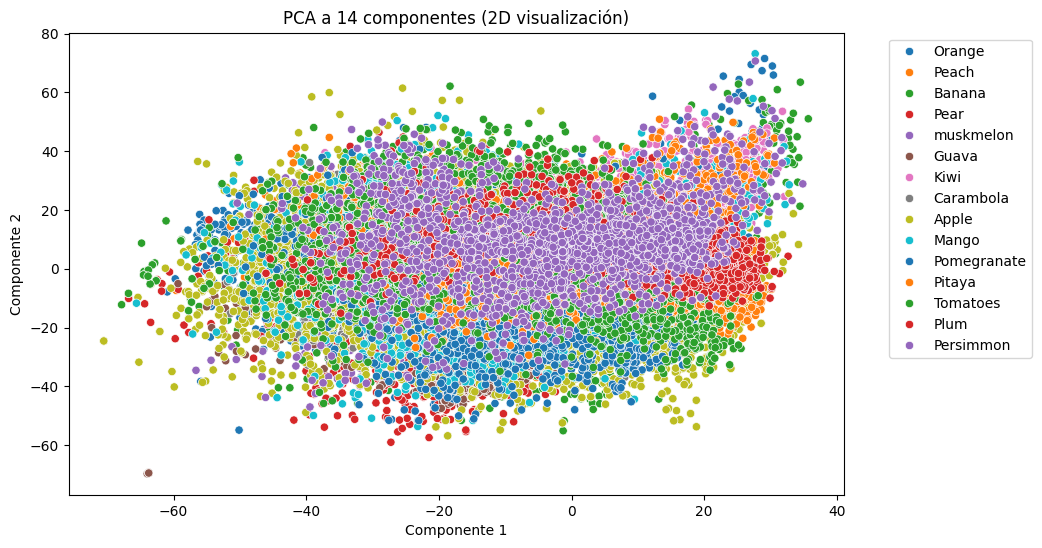

              precision    recall  f1-score   support

      Orange       0.63      0.89      0.74      2237
       Peach       0.76      0.69      0.72       605
      Banana       0.74      0.66      0.69       416
        Pear       0.94      0.96      0.95      3940
   muskmelon       0.92      0.92      0.92      1697
       Guava       0.70      0.63      0.67       831
        Kiwi       0.67      0.57      0.62       602
   Carambola       0.80      0.67      0.73       526
       Apple       0.88      0.62      0.72       602
       Mango       0.77      0.77      0.77       414
 Pomegranate       0.88      0.68      0.77       500
      Pitaya       0.92      0.93      0.93       460
    Tomatoes       0.91      0.65      0.76       433
        Plum       0.88      0.66      0.75       435
   Persimmon       0.85      0.62      0.72       416

    accuracy                           0.82     14114
   macro avg       0.82      0.73      0.76     14114
weighted avg       0.83   

In [ ]:
# Librerías necesarias
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Cargar el dataset
df = pd.read_csv('/content/drive/MyDrive/Proyecto Jupiter/dataset_completo.csv')

# Mapeo de etiquetas
label_to_index = {label: idx for idx, label in enumerate(sorted(df['tipo'].unique()))}
df['label'] = df['tipo'].map(label_to_index)

# División estratificada
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# Parámetros
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

# Función para decodificar imágenes
def decode_img(path, label):
    img = tf.io.read_file(path)
    ext = tf.strings.lower(tf.strings.split(path, '.')[-1])
    def decode_jpg(): return tf.image.decode_jpeg(img, channels=3)
    def decode_png(): return tf.image.decode_png(img, channels=3)
    img = tf.cond(tf.equal(ext, 'png'), decode_png, decode_jpg)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

# Dataset generator
def df_to_dataset(df, shuffle=True):
    paths = df['ruta'].values
    labels = df['label'].values
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(decode_img, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df))
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Dataset de entrenamiento y prueba
train_ds = df_to_dataset(train_df)
test_ds = df_to_dataset(test_df, shuffle=False)

# Función para vectorizar imágenes (flatten)
def image_to_vector(path):
    img_bytes = tf.io.read_file(path)
    ext = tf.strings.lower(tf.strings.split(path, '.')[-1])
    def decode_jpg(): return tf.image.decode_jpeg(img_bytes, channels=3)
    def decode_png(): return tf.image.decode_png(img_bytes, channels=3)
    img = tf.cond(tf.equal(ext, 'png'), decode_png, decode_jpg)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.reshape(img, [-1])  # a vector plano
    return img

# Aplicamos a todas las imágenes
paths = tf.constant(df['ruta'].values)
ds = tf.data.Dataset.from_tensor_slices(paths)
ds = ds.map(image_to_vector, num_parallel_calls=tf.data.AUTOTUNE)
ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

image_vectors = np.vstack([batch.numpy() for batch in ds])
labels = df['label'].values

# Reducción de dimensionalidad a 14 componentes (por número de clases)
pca = PCA(n_components=14)
X_reduced = pca.fit_transform(image_vectors)

# Visualización con las 2 primeras componentes
plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_reduced[:, 0], y=X_reduced[:, 1], hue=df['tipo'], palette='tab10')
plt.title("PCA a 14 componentes (2D visualización)")
plt.xlabel("Componente 1")
plt.ylabel("Componente 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

# Clasificación con SVM
X_train, X_test, y_train, y_test = train_test_split(X_reduced, labels, test_size=0.2, stratify=labels, random_state=42)
clf = SVC(kernel='rbf')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Resultados
print(classification_report(y_test, y_pred, target_names=df['tipo'].unique()))

# aumentemos a 100 dimensiones

In [ ]:
# Librerías necesarias
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Cargar el dataset
df = pd.read_csv('/content/drive/MyDrive/Proyecto Jupiter/dataset_completo.csv')

# Mapeo de etiquetas
label_to_index = {label: idx for idx, label in enumerate(sorted(df['tipo'].unique()))}
df['label'] = df['tipo'].map(label_to_index)

# División estratificada
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# Parámetros
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

# Función para decodificar imágenes
def decode_img(path, label):
    img = tf.io.read_file(path)
    ext = tf.strings.lower(tf.strings.split(path, '.')[-1])
    def decode_jpg(): return tf.image.decode_jpeg(img, channels=3)
    def decode_png(): return tf.image.decode_png(img, channels=3)
    img = tf.cond(tf.equal(ext, 'png'), decode_png, decode_jpg)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

# Dataset generator
def df_to_dataset(df, shuffle=True):
    paths = df['ruta'].values
    labels = df['label'].values
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(decode_img, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df))
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Dataset de entrenamiento y prueba
train_ds = df_to_dataset(train_df)
test_ds = df_to_dataset(test_df, shuffle=False)

# Función para vectorizar imágenes (flatten)
def image_to_vector(path):
    img_bytes = tf.io.read_file(path)
    ext = tf.strings.lower(tf.strings.split(path, '.')[-1])
    def decode_jpg(): return tf.image.decode_jpeg(img_bytes, channels=3)
    def decode_png(): return tf.image.decode_png(img_bytes, channels=3)
    img = tf.cond(tf.equal(ext, 'png'), decode_png, decode_jpg)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.reshape(img, [-1])  # a vector plano
    return img

# Aplicamos a todas las imágenes
paths = tf.constant(df['ruta'].values)
ds = tf.data.Dataset.from_tensor_slices(paths)
ds = ds.map(image_to_vector, num_parallel_calls=tf.data.AUTOTUNE)
ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

image_vectors = np.vstack([batch.numpy() for batch in ds])
labels = df['label'].values

# Reducción de dimensionalidad a 100 componentes (por número de clases)
pca = PCA(n_components=100)
X_reduced = pca.fit_transform(image_vectors)

# Clasificación con SVM
X_train, X_test, y_train, y_test = train_test_split(X_reduced, labels, test_size=0.2, stratify=labels, random_state=42)
clf = SVC(kernel='rbf')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Resultados
print(classification_report(y_test, y_pred, target_names=df['tipo'].unique()))

              precision    recall  f1-score   support

      Orange       0.75      0.98      0.85      2237
       Peach       0.91      0.84      0.87       605
      Banana       0.97      0.89      0.93       416
        Pear       0.98      0.98      0.98      3940
   muskmelon       0.98      0.95      0.96      1697
       Guava       0.88      0.82      0.85       831
        Kiwi       0.94      0.89      0.91       602
   Carambola       0.98      0.83      0.90       526
       Apple       0.93      0.84      0.88       602
       Mango       0.95      0.91      0.93       414
 Pomegranate       0.99      0.86      0.92       500
      Pitaya       1.00      1.00      1.00       460
    Tomatoes       0.96      0.81      0.88       433
        Plum       0.97      0.84      0.90       435
   Persimmon       0.99      0.78      0.87       416

    accuracy                           0.92     14114
   macro avg       0.94      0.88      0.91     14114
weighted avg       0.93   

# 100 dimensiones usando filtro a ver que tal

In [ ]:
# ============================================================
# 🔹 PARTE 1: Calcular bins comunes de tu selección
# ============================================================
import os
from PIL import Image
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# --- parámetros robustos ---
base_path = '/content/drive/MyDrive/Proyecto Jupiter/archive'
excluir_carpetas = ["total", "Total"]
ultimas_carpetas = ["Apple F", "Mango", "Peach", "Pitaya", "Plum"]

rango_manual = {
    "Banana": ["Banana0899.png", "Banana0900.png", "Banana0901.png", "Banana0902.png",
               "Banana0903.png", "Banana0904.png", "Banana0905.png", "Banana0906.png",
               "Banana0907.png", "Banana0908.png"],
    "Carambola": [f"Carambola 00{i:03d}.png" for i in range(193, 203)],
    "muskmelon": [f"Muskmelon 00{i:04d}.png" for i in range(2063, 2073)],
    "Orange": ([f"Orange00{i:04d}.png" for i in range(2924, 2930)] +
               [f"Orange00{i:04d}.png" for i in range(2931, 2935)]),
    "Pear": ([f"Pear {i}.png" for i in range(4, 11)] +
             [f"Pear {i}.png" for i in range(14, 18)]),
    "Persimmon": [f"Persimmon20{i:02d}.png" for i in range(19, 29)],
    "Pomegranate": [f"Pomegranet0014{i:02d}.png" for i in range(62, 72)],
    "Tomatoes": [f"Tamotoes0020{i:02d}.png" for i in range(87, 97)],
}

TARGET_SIZE = (256, 256)
NIVELES = 32
FACTOR = 256 // NIVELES

def cuantizar(arr):
    return (arr // FACTOR) * FACTOR

def cargar_bins_unicos(imagen_path, size=TARGET_SIZE):
    try:
        with Image.open(imagen_path).convert("RGB") as img:
            img = img.resize(size, resample=Image.NEAREST)
            arr = np.array(img, dtype=np.uint8)
            arr_q = cuantizar(arr)
            h, w, _ = arr_q.shape
            arr_flat = arr_q.reshape(-1, 3)
            colores = set(map(tuple, arr_flat))
            return colores, (h*w), arr_q
    except:
        return set(), 0, None

bins_comunes = None
contador = 0
imagenes_q = []

def procesa_lista(ruta_base, archivos):
    global bins_comunes, contador
    for img_name in archivos:
        img_path = os.path.join(ruta_base, img_name)
        colores_img, n_pix, arr_q = cargar_bins_unicos(img_path)
        if n_pix == 0:
            continue
        if bins_comunes is None:
            bins_comunes = colores_img
        else:
            bins_comunes = bins_comunes.intersection(colores_img)
        contador += 1
        if arr_q is not None:
            imagenes_q.append(arr_q)

for fruta in os.listdir(base_path):
    fruta_path = os.path.join(base_path, fruta)
    if not os.path.isdir(fruta_path):
        continue
    elementos = os.listdir(fruta_path)
    hay_subcarpetas = any(os.path.isdir(os.path.join(fruta_path, el)) for el in elementos)
    if hay_subcarpetas:
        for subcarpeta in elementos:
            if any(pal in subcarpeta for pal in excluir_carpetas):
                continue
            sub_path = os.path.join(fruta_path, subcarpeta)
            if not os.path.isdir(sub_path):
                continue
            imagenes_archivos = sorted([f for f in os.listdir(sub_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
            if fruta in rango_manual:
                seleccionadas = [f for f in imagenes_archivos if f in rango_manual[fruta]]
            elif subcarpeta in ultimas_carpetas:
                seleccionadas = imagenes_archivos[-10:]
            else:
                seleccionadas = imagenes_archivos[:10]
            procesa_lista(sub_path, seleccionadas)
    else:
        imagenes_archivos = sorted([f for f in elementos if f.lower().endswith(('.png', '.jpg', '.jpeg'))])
        if fruta in rango_manual:
            seleccionadas = [f for f in imagenes_archivos if f in rango_manual[fruta]]
        elif fruta in ultimas_carpetas:
            seleccionadas = imagenes_archivos[-10:]
        else:
            seleccionadas = imagenes_archivos[:10]
        procesa_lista(fruta_path, seleccionadas)

print(f"✅ Bins comunes calculados: {len(bins_comunes)} a partir de {contador} imágenes")

# ============================================================
# 🔹 PARTE 2: Clasificación con bins_comunes
# ============================================================
# Dataset CSV
df = pd.read_csv('/content/drive/MyDrive/Proyecto Jupiter/dataset_completo.csv')
label_to_index = {label: idx for idx, label in enumerate(sorted(df['tipo'].unique()))}
df['label'] = df['tipo'].map(label_to_index)

IMG_SIZE = (128, 128)

def decode_img_with_filter(path, label):
    img_bytes = tf.io.read_file(path)
    ext = tf.strings.lower(tf.strings.split(path, '.')[-1])
    def decode_jpg(): return tf.image.decode_jpeg(img_bytes, channels=3)
    def decode_png(): return tf.image.decode_png(img_bytes, channels=3)
    img = tf.cond(tf.equal(ext, 'png'), decode_png, decode_jpg)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.uint8)
    # Cuantizar
    arr = (img.numpy() // FACTOR) * FACTOR
    # Filtrar según bins_comunes
    mask = np.array([tuple(p) in bins_comunes for p in arr.reshape(-1, 3)])
    arr = arr.reshape(-1, 3)[mask]
    # Si queda vacío, fallback
    if arr.size == 0:
        arr = np.zeros((1, 3), dtype=np.uint8)
    arr = arr.flatten().astype(np.float32) / 255.0
    return arr, label

# Vectorización de todas las imágenes
X, y = [], []
for path, label in zip(df['ruta'].values, df['label'].values):
    vec, lab = decode_img_with_filter(path, label)
    X.append(vec)
    y.append(lab)

# Padding a mismo tamaño
max_len = max(len(v) for v in X)
X_padded = np.array([np.pad(v, (0, max_len-len(v))) for v in X])
y = np.array(y)

# PCA + SVM
pca = PCA(n_components=100)
X_reduced = pca.fit_transform(X_padded)

X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, stratify=y, random_state=42)
clf = SVC(kernel='rbf')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print("\n📊 Resultados de clasificación con filtro de bins comunes:\n")
print(classification_report(y_test, y_pred, target_names=df['tipo'].unique()))

✅ Bins comunes calculados: 165 a partir de 231 imágenes

📊 Resultados de clasificación con filtro de bins comunes:

              precision    recall  f1-score   support

      Orange       0.38      0.76      0.51      2237
       Peach       0.48      0.21      0.29       605
      Banana       0.43      0.19      0.27       416
        Pear       0.77      0.94      0.85      3940
   muskmelon       0.74      0.85      0.79      1697
       Guava       0.31      0.10      0.15       831
        Kiwi       0.50      0.19      0.27       602
   Carambola       0.61      0.41      0.49       526
       Apple       0.61      0.23      0.33       602
       Mango       0.71      0.12      0.21       414
 Pomegranate       0.52      0.30      0.38       500
      Pitaya       0.86      0.76      0.81       460
    Tomatoes       0.45      0.11      0.18       433
        Plum       0.62      0.22      0.33       435
   Persimmon       0.64      0.47      0.54       416

    accuracy      

# aumentemos a 200 dimensiones

In [ ]:
# Librerías necesarias
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import classification_report

# Cargar el dataset
df = pd.read_csv('/content/drive/MyDrive/Proyecto Jupiter/dataset_completo.csv')

# Mapeo de etiquetas
label_to_index = {label: idx for idx, label in enumerate(sorted(df['tipo'].unique()))}
df['label'] = df['tipo'].map(label_to_index)

# División estratificada
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

# Parámetros
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

# Función para decodificar imágenes
def decode_img(path, label):
    img = tf.io.read_file(path)
    ext = tf.strings.lower(tf.strings.split(path, '.')[-1])
    def decode_jpg(): return tf.image.decode_jpeg(img, channels=3)
    def decode_png(): return tf.image.decode_png(img, channels=3)
    img = tf.cond(tf.equal(ext, 'png'), decode_png, decode_jpg)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

# Dataset generator
def df_to_dataset(df, shuffle=True):
    paths = df['ruta'].values
    labels = df['label'].values
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    ds = ds.map(decode_img, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df))
    return ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Dataset de entrenamiento y prueba
train_ds = df_to_dataset(train_df)
test_ds = df_to_dataset(test_df, shuffle=False)

# Función para vectorizar imágenes (flatten)
def image_to_vector(path):
    img_bytes = tf.io.read_file(path)
    ext = tf.strings.lower(tf.strings.split(path, '.')[-1])
    def decode_jpg(): return tf.image.decode_jpeg(img_bytes, channels=3)
    def decode_png(): return tf.image.decode_png(img_bytes, channels=3)
    img = tf.cond(tf.equal(ext, 'png'), decode_png, decode_jpg)
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.reshape(img, [-1])  # a vector plano
    return img

# Aplicamos a todas las imágenes
paths = tf.constant(df['ruta'].values)
ds = tf.data.Dataset.from_tensor_slices(paths)
ds = ds.map(image_to_vector, num_parallel_calls=tf.data.AUTOTUNE)
ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

image_vectors = np.vstack([batch.numpy() for batch in ds])
labels = df['label'].values

# Reducción de dimensionalidad a 200 componentes (por número de clases)
pca = PCA(n_components=200)
X_reduced = pca.fit_transform(image_vectors)

# Clasificación con SVM
X_train, X_test, y_train, y_test = train_test_split(X_reduced, labels, test_size=0.2, stratify=labels, random_state=42)
clf = SVC(kernel='rbf')
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Resultados
print(classification_report(y_test, y_pred, target_names=df['tipo'].unique()))

              precision    recall  f1-score   support

      Orange       0.75      0.98      0.85      2237
       Peach       0.91      0.84      0.87       605
      Banana       0.98      0.89      0.93       416
        Pear       0.99      0.98      0.98      3940
   muskmelon       0.98      0.95      0.96      1697
       Guava       0.89      0.84      0.86       831
        Kiwi       0.94      0.90      0.92       602
   Carambola       0.99      0.83      0.90       526
       Apple       0.93      0.85      0.89       602
       Mango       0.96      0.91      0.94       414
 Pomegranate       0.99      0.86      0.92       500
      Pitaya       1.00      1.00      1.00       460
    Tomatoes       0.97      0.81      0.88       433
        Plum       0.96      0.84      0.90       435
   Persimmon       0.99      0.79      0.88       416

    accuracy                           0.92     14114
   macro avg       0.95      0.88      0.91     14114
weighted avg       0.93   

La precisión no llega a un mínimo exigible, probaremos con RandomForest, aumentaremos el tamaño de la imagen al doble, y pondremos 28 dimensiones a ver que tal así, el tiempo fue de 14 minutos, aunque se multiplique por 8, seguiría siendo menos que la red neuronal

# Probamos con Random Forest con PCA

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Tamaño aumentado
IMG_SIZE = (256, 256)
BATCH_SIZE = 32

df = pd.read_csv('/content/drive/MyDrive/Proyecto Jupiter/dataset_completo.csv')
label_to_index = {label: idx for idx, label in enumerate(sorted(df['tipo'].unique()))}
df['label'] = df['tipo'].map(label_to_index)

In [ ]:
def extract_vector(path):
    img_bytes = tf.io.read_file(path)
    ext = tf.strings.lower(tf.strings.split(path, '.')[-1])

    def decode_jpg(): return tf.image.decode_jpeg(img_bytes, channels=3)
    def decode_png(): return tf.image.decode_png(img_bytes, channels=3)

    img = tf.cond(tf.equal(ext, 'png'), decode_png, decode_jpg)
    img.set_shape([None, None, 3])
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    return tf.reshape(img, [-1])  # Flatten

In [ ]:
paths = df['ruta'].values
ds = tf.data.Dataset.from_tensor_slices(paths)
ds = ds.map(extract_vector, num_parallel_calls=tf.data.AUTOTUNE)
ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Convertir a array NumPy
X = np.vstack([batch.numpy() for batch in ds])
y = df['label'].values

In [ ]:
pca = PCA(n_components=28)
X_reduced = pca.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, stratify=y, random_state=42)

rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# Reporte de métricas
print(classification_report(y_test, y_pred, target_names=df['tipo'].unique()))

              precision    recall  f1-score   support

      Orange       0.60      0.97      0.74      2237
       Peach       0.89      0.70      0.78       605
      Banana       0.86      0.73      0.79       416
        Pear       0.97      0.96      0.97      3940
   muskmelon       0.98      0.93      0.96      1697
       Guava       0.85      0.69      0.76       831
        Kiwi       0.86      0.64      0.73       602
   Carambola       0.92      0.78      0.84       526
       Apple       0.94      0.74      0.83       602
       Mango       0.90      0.82      0.86       414
 Pomegranate       0.97      0.74      0.84       500
      Pitaya       0.99      0.97      0.98       460
    Tomatoes       0.95      0.72      0.82       433
        Plum       0.93      0.66      0.77       435
   Persimmon       0.97      0.67      0.80       416

    accuracy                           0.86     14114
   macro avg       0.91      0.78      0.83     14114
weighted avg       0.89   

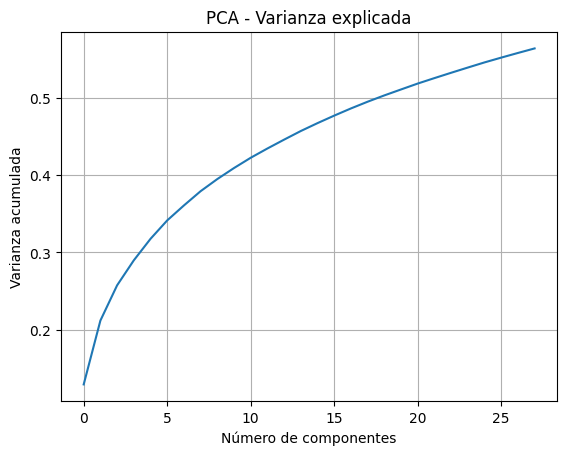

In [ ]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Número de componentes')
plt.ylabel('Varianza acumulada')
plt.title('PCA - Varianza explicada')
plt.grid(True)
plt.show()

Vale, la varianza es muy baja, vamos a aumentara con 4 veces el tramo de 15 a 28 que sube 0.1 aprox, para subir un 0.4, será algo menos, redondeando probaremos con 90 dimensiones, dando más sentido a usar RandomForest frente a SVM

In [ ]:
pca = PCA(n_components=90)
X_reduced = pca.fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, stratify=y, random_state=42)

rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# Reporte de métricas
print(classification_report(y_test, y_pred, target_names=df['tipo'].unique()))

              precision    recall  f1-score   support

      Orange       0.55      0.99      0.71      2237
       Peach       0.93      0.71      0.81       605
      Banana       0.98      0.74      0.84       416
        Pear       0.99      0.96      0.97      3940
   muskmelon       1.00      0.92      0.96      1697
       Guava       0.92      0.70      0.80       831
        Kiwi       0.96      0.63      0.76       602
   Carambola       0.95      0.78      0.85       526
       Apple       0.99      0.72      0.83       602
       Mango       0.98      0.78      0.87       414
 Pomegranate       0.99      0.73      0.84       500
      Pitaya       1.00      0.97      0.98       460
    Tomatoes       0.99      0.73      0.84       433
        Plum       0.98      0.62      0.76       435
   Persimmon       0.99      0.69      0.81       416

    accuracy                           0.86     14114
   macro avg       0.95      0.78      0.84     14114
weighted avg       0.91   

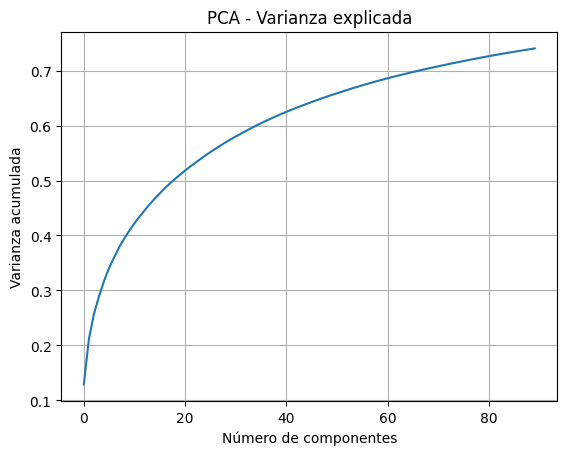

In [ ]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Número de componentes')
plt.ylabel('Varianza acumulada')
plt.title('PCA - Varianza explicada')
plt.grid(True)
plt.show()

los datos han mejorado bastante pero la naranja no tenemos buena precisión, vamos a probar con un GridSearch para buscar diferentes tipos de RandomForest a ver que obtenemos

In [ ]:
param_grid = {
    'n_estimators': [200, 300],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2', None]
}

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print("Mejores parámetros:", grid_search.best_params_)
print("Mejor accuracy:", grid_search.best_score_)

Fitting 3 folds for each of 72 candidates, totalling 216 fits


In [ ]:
from sklearn.metrics import classification_report

# Suponiendo que grid_search ya está entrenado:
best_params = grid_search.best_params_

# Creamos el modelo con los mejores parámetros
best_rf = RandomForestClassifier(**best_params, random_state=42)
best_rf.fit(X_train, y_train)

# Predecimos en test
y_pred = best_rf.predict(X_test)

# Mostramos el reporte
print(classification_report(y_test, y_pred, target_names=df['tipo'].unique()))

In [ ]:
import joblib
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Guardar el modelo entrenado
joblib.dump(rf, '/content/drive/MyDrive/Proyecto Jupiter/random_forest_model.joblib')

# Generar predicciones (por si no lo tienes ya hecho)
y_pred = rf.predict(X_test)

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=df['tipo'].unique())

plt.figure(figsize=(12, 12))
disp.plot(cmap='Blues', ax=plt.gca(), xticks_rotation='vertical')
plt.title("Matriz de Confusión - Random Forest")
plt.show()

In [ ]:
import joblib

# Cargar el modelo
rf_loaded = joblib.load('/content/drive/MyDrive/Proyecto Jupiter/random_forest_model.joblib')

# Y ahora Random Forest sin PCA

In [ ]:
!pip install tensorflow

import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Tamaño aumentado
IMG_SIZE = (256, 256)
BATCH_SIZE = 32

df = pd.read_csv('/content/drive/MyDrive/Proyecto Jupiter/dataset_completo.csv')
label_to_index = {label: idx for idx, label in enumerate(sorted(df['tipo'].unique()))}
df['label'] = df['tipo'].map(label_to_index)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.7/620.7 MB 620.7 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 86.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 105.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 108.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.5/72.5 kB 3.5 MB/s eta 0:00:00


In [ ]:
def extract_vector(path):
    img_bytes = tf.io.read_file(path)
    ext = tf.strings.lower(tf.strings.split(path, '.')[-1])

    def decode_jpg(): return tf.image.decode_jpeg(img_bytes, channels=3)
    def decode_png(): return tf.image.decode_png(img_bytes, channels=3)

    img = tf.cond(tf.equal(ext, 'png'), decode_png, decode_jpg)
    img.set_shape([None, None, 3])
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.cast(img, tf.float32) / 255.0
    return tf.reshape(img, [-1])  # Flatten

In [ ]:
paths = df['ruta'].values
ds = tf.data.Dataset.from_tensor_slices(paths)
ds = ds.map(extract_vector, num_parallel_calls=tf.data.AUTOTUNE)
ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

# Convertir a array NumPy
X = np.vstack([batch.numpy() for batch in ds])
y = df['label'].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

rf = RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

# Reporte de métricas
print(classification_report(y_test, y_pred, target_names=df['tipo'].unique()))

              precision    recall  f1-score   support

      Orange       0.60      1.00      0.75      2237
       Peach       1.00      0.73      0.84       605
      Banana       1.00      0.81      0.89       416
        Pear       0.99      0.97      0.98      3940
   muskmelon       1.00      0.92      0.96      1697
       Guava       0.96      0.74      0.84       831
        Kiwi       0.94      0.84      0.88       602
   Carambola       1.00      0.82      0.90       526
       Apple       1.00      0.78      0.88       602
       Mango       0.99      0.80      0.89       414
 Pomegranate       1.00      0.81      0.89       500
      Pitaya       1.00      1.00      1.00       460
    Tomatoes       1.00      0.76      0.86       433
        Plum       0.99      0.72      0.84       435
   Persimmon       1.00      0.76      0.86       416

    accuracy                           0.89     14114
   macro avg       0.97      0.83      0.88     14114
weighted avg       0.93   

Probaremos con un GridSearchCV para buscar un RandomForest más adecuado

In [ ]:
param_grid = {
    'n_estimators': [100, 300],
    'max_depth': [10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', None]
}

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print("Mejores parámetros:", grid_search.best_params_)
print("Mejor accuracy:", grid_search.best_score_)

Fitting 3 folds for each of 32 candidates, totalling 96 fits


Incluso reduciendo algunos parámetros colab me sigue echando.  
Dado que ya tenemos una red neuronal muy buena y esta busqueda quedama más teórica que práctica la doy por concluida

In [ ]:
from sklearn.metrics import classification_report

# Suponiendo que grid_search ya está entrenado:
best_params = grid_search.best_params_

# Creamos el modelo con los mejores parámetros
best_rf = RandomForestClassifier(**best_params, random_state=42)
best_rf.fit(X_train, y_train)

# Predecimos en test
y_pred = best_rf.predict(X_test)

# Mostramos el reporte
print(classification_report(y_test, y_pred, target_names=df['tipo'].unique()))

In [ ]:
import joblib
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Guardar el modelo entrenado
joblib.dump(rf, '/content/drive/MyDrive/Proyecto Jupiter/random_forest_model_sinPCA.joblib')

# Generar predicciones (por si no lo tienes ya hecho)
y_pred = rf.predict(X_test)

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=df['tipo'].unique())

plt.figure(figsize=(12, 12))
disp.plot(cmap='Blues', ax=plt.gca(), xticks_rotation='vertical')
plt.title("Matriz de Confusión - Random Forest")
plt.show()

In [ ]:
import joblib

# Cargar el modelo
rf_loaded = joblib.load('/content/drive/MyDrive/Proyecto Jupiter/random_forest_model_sinPCA.joblib')

# Conclusiones

- El dataset es muy grande por lo que para entrenar habría sido adecuado tomar una muestra algo más pequeña para aligerar el entrenamiento y evitar que google colab cerrara la sesión.  
- Para usar la reducción de la dimensionalidad es conveniente ver la curva de la información retenida según la dimensión para poder elegir una más adecuada.  
- Hay que tener en cuenta la modificación de la información en un resize.  
- Los pixeles únicos era frotar una lampara y no salió el genio, pero habría estado bien si hubiese salido.  
- El filtro de ruido de fondo no funciona por la gran variedad de fondos en las imagenes. Si hubiese sido una bandeja mate, misma posición de la camara, sin manos quiza habría sido útil.